In [1]:
import os,sys
import numpy as np
import copy
import time
import h5py
import pandas as pd

codepath = '/user_data/mmhender/imStat/code'
sys.path.append(codepath)
from utils import nsd_utils, default_paths, coco_utils
import PIL
import matplotlib.pyplot as plt
from matplotlib import cm
from model_fitting import initialize_fitting
from plotting_and_analysis import plot_utils 

Initializing coco api...
loading annotations into memory...
Done (t=0.55s)
creating index...
index created!
loading annotations into memory...
Done (t=14.49s)
creating index...
index created!
Initializing coco api...
loading annotations into memory...
Done (t=0.39s)
creating index...
index created!
loading annotations into memory...
Done (t=12.63s)
creating index...
index created!


In [4]:
cat_objects, cat_names, cat_ids, supcat_names, ids_each_supcat = coco_utils.get_coco_cat_info()

subject = 1;
# fn2load = os.path.join(default_paths.sketch_token_feat_path, 'LDA','S%d_LDA_animacy.npy'%subject)
fn2load = os.path.join(default_paths.sketch_token_feat_path, 'LDA','S%d_LDA_all_supcat.npy'%subject)
pc_result = np.load(fn2load, allow_pickle=True).item()

scores_each_prf = pc_result['scores']
wts_each_prf = pc_result['wts']
trn_acc_each_prf = pc_result['trn_acc']
trn_acc_each_prf = pc_result['trn_dprime']
val_acc_each_prf = pc_result['val_acc']
val_acc_each_prf = pc_result['val_dprime']
labels_pred_each_prf = pc_result['labels_pred'];
labels_actual_each_prf = pc_result['labels_actual'];


In [5]:
prf_model_index = 697
coco_labels_fn = os.path.join(default_paths.stim_labels_root, 'S%d_within_prf'%subject, \
                              'S%d_cocolabs_binary_prf%d.csv'%(subject, prf_model_index))
print('Reading labels from %s...'%coco_labels_fn)
coco_df = pd.read_csv(coco_labels_fn, index_col=0)

Reading labels from /user_data/mmhender/nsd_stimuli/labels/S1_within_prf/S1_cocolabs_binary_prf697.csv...


In [6]:
# Params for the spatial aspect of the model (possible pRFs)
aperture_rf_range = 1.1
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range)    
n_prfs = models.shape[0]

most extreme RF positions:
[-0.55 -0.55  0.04]
[0.55       0.55       0.40000001]


In [7]:
supcat_labels = np.array(coco_df)[:,0:12]

labels = [np.where(supcat_labels[ii,:])[0] for ii in range(supcat_labels.shape[0])]
labels = np.array([ll[0] if len(ll)>0 else -1 for ll in labels])

ims_to_use = np.sum(supcat_labels, axis=1)==1
print('Proportion of images that have exactly one super-cat label:')
print(np.mean(ims_to_use))

print('Unique labels:')
unvals = np.unique(labels[ims_to_use])
print(np.unique(labels[ims_to_use]))

labels_actual = labels[ims_to_use]

labels_pred = labels_pred_each_prf[prf_model_index][ims_to_use]

n_categ = len(np.unique(labels_actual))
# n_categ = len(supcat_names)
conf_mat = np.zeros(shape=(n_categ, n_categ))
for cc1 in range(n_categ):
    for cc2 in range(n_categ):
        
        conf_mat[cc1, cc2] = np.sum((labels_actual==cc1) & (labels_pred==cc2))

Proportion of images that have exactly one super-cat label:
0.5314
Unique labels:
[ 0  1  2  3  4  5  6  7  8  9 10 11]


Text(0.5, 1.0, 'pRF 697')

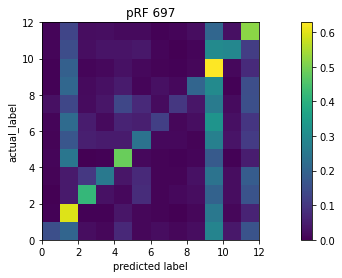

In [8]:
plt.figure();
conf_mat_norm = conf_mat/np.tile(np.sum(conf_mat, axis=1, keepdims=True), [1,n_categ])
plt.pcolormesh(conf_mat_norm)
plt.colorbar()
plt.xlabel('predicted label')
plt.ylabel('actual_label')
plt.axis('square')
# plt.gca().invert_yaxis()
plt.title('pRF %d'%prf_model_index)

Text(0.5, 0.98, 'pRF 697')

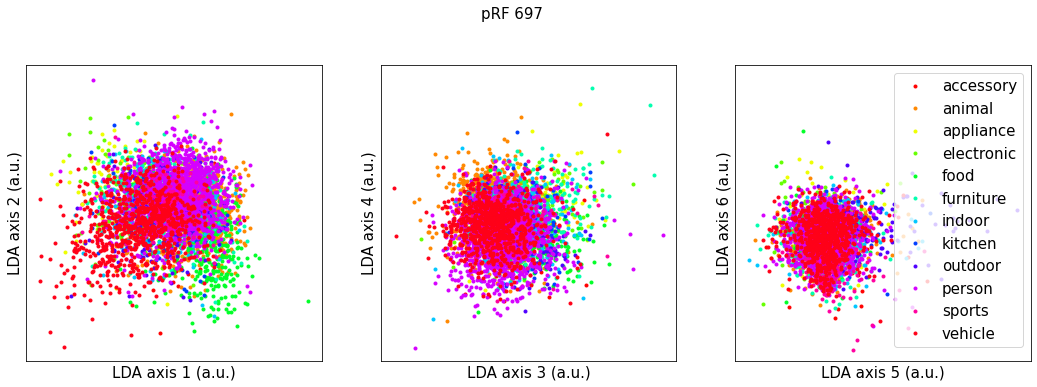

In [55]:

scores = scores_each_prf[prf_model_index][ims_to_use,:]

plot_utils.set_all_font_sizes(15)
plt.figure(figsize=(18,6));

ax2plot_list = [[0,1], [2,3], [4,5]]

# colors = cm.Set1(np.linspace(0,1,len(supcat_names)))
colors = cm.hsv(np.linspace(0,1,len(supcat_names)))

for ai, ax2plot in enumerate(ax2plot_list):
    plt.subplot(1,3,ai+1)
    
    lh=[]
    for sc, scname in enumerate(supcat_names):

        ims_in_supcat = labels_actual==sc
        meanvals = np.mean(scores[ims_in_supcat,:], axis=0)
        semvals = np.std(scores[ims_in_supcat,:], axis=0)/np.sqrt(np.sum(ims_in_supcat))

        h=plt.plot(scores[ims_in_supcat,ax2plot[0]], \
                 scores[ims_in_supcat,ax2plot[1]],'.',alpha=1,color=colors[sc])

#         h, = plt.plot(meanvals[ax2plot[0]], meanvals[ax2plot[1]],'.',markersize=10,color=colors[sc])
#         plt.errorbar(x = meanvals[ax2plot[0]], y = meanvals[ax2plot[1]], \
#                      yerr = semvals[ax2plot[1]], xerr = semvals[ax2plot[0]], color=colors[sc])
        lh.append(h[0])

    if ai==2:
        plt.legend(handles=lh,labels=supcat_names)
    
    plt.axis('square')
    plt.xlabel('LDA axis %d (a.u.)'%(ax2plot[0]+1))
    plt.ylabel('LDA axis %d (a.u.)'%(ax2plot[1]+1))

    plt.xticks([])
    plt.yticks([])

    # plt.title('x,y,sigma=[%.2f, %.2f, %.2f]'
    #       %(models[mm,0], models[mm,1], models[mm,2]));

#     plt.title('LDA axes %d and %d'%(ax2plot[0], ax2plot[1]));

plt.suptitle('pRF %d'%prf_model_index)

Text(0.5, 0.98, 'pRF 697')

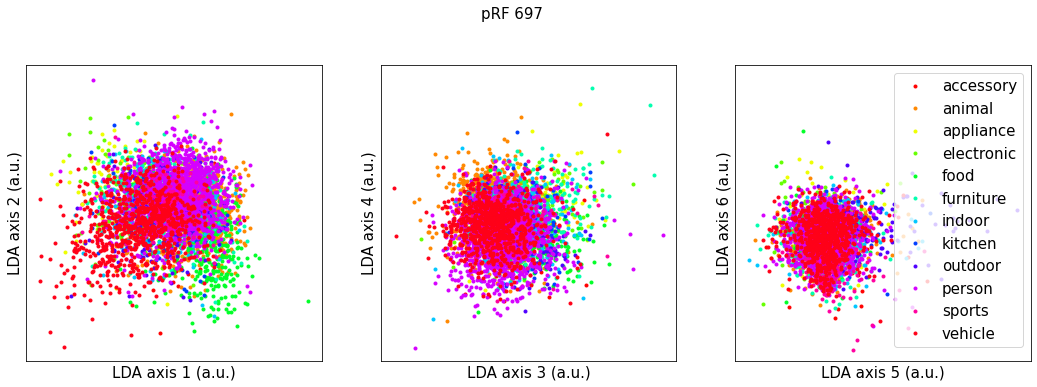

In [55]:

scores = scores_each_prf[prf_model_index][ims_to_use,:]

plot_utils.set_all_font_sizes(15)
plt.figure(figsize=(18,6));

ax2plot_list = [[0,1]]

# colors = cm.Set1(np.linspace(0,1,len(supcat_names)))
colors = cm.hsv(np.linspace(0,1,len(supcat_names)))

for ai, ax2plot in enumerate(ax2plot_list):
    plt.subplot(1,3,ai+1)
    
    lh=[]
    for sc, scname in enumerate(supcat_names):

        ims_in_supcat = labels_actual==sc
        meanvals = np.mean(scores[ims_in_supcat,:], axis=0)
        semvals = np.std(scores[ims_in_supcat,:], axis=0)/np.sqrt(np.sum(ims_in_supcat))

        h=plt.plot(scores[ims_in_supcat,ax2plot[0]], \
                 scores[ims_in_supcat,ax2plot[1]],'.',alpha=1,color=colors[sc])

#         h, = plt.plot(meanvals[ax2plot[0]], meanvals[ax2plot[1]],'.',markersize=10,color=colors[sc])
#         plt.errorbar(x = meanvals[ax2plot[0]], y = meanvals[ax2plot[1]], \
#                      yerr = semvals[ax2plot[1]], xerr = semvals[ax2plot[0]], color=colors[sc])
        lh.append(h[0])

    if ai==2:
        plt.legend(handles=lh,labels=supcat_names)
    
    plt.axis('square')
    plt.xlabel('LDA axis %d (a.u.)'%(ax2plot[0]+1))
    plt.ylabel('LDA axis %d (a.u.)'%(ax2plot[1]+1))

    plt.xticks([])
    plt.yticks([])

    # plt.title('x,y,sigma=[%.2f, %.2f, %.2f]'
    #       %(models[mm,0], models[mm,1], models[mm,2]));

#     plt.title('LDA axes %d and %d'%(ax2plot[0], ax2plot[1]));

plt.suptitle('pRF %d'%prf_model_index)

Text(0.5, 0.98, 'pRF 697')

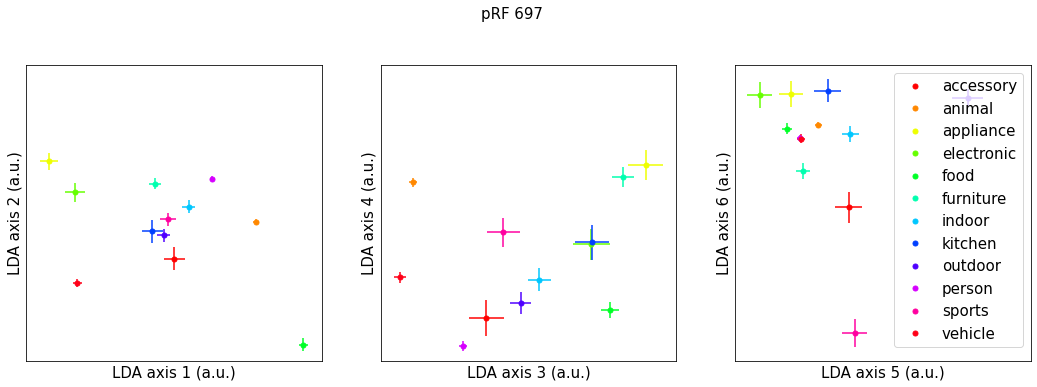

In [56]:

scores = scores_each_prf[prf_model_index][ims_to_use,:]

plot_utils.set_all_font_sizes(15)
plt.figure(figsize=(18,6));

ax2plot_list = [[0,1], [2,3], [4,5]]

# colors = cm.Set1(np.linspace(0,1,len(supcat_names)))
colors = cm.hsv(np.linspace(0,1,len(supcat_names)))

for ai, ax2plot in enumerate(ax2plot_list):
    plt.subplot(1,3,ai+1)
    
    lh=[]
    for sc, scname in enumerate(supcat_names):

        ims_in_supcat = labels_actual==sc
        meanvals = np.mean(scores[ims_in_supcat,:], axis=0)
        semvals = np.std(scores[ims_in_supcat,:], axis=0)/np.sqrt(np.sum(ims_in_supcat))

#         h=plt.plot(scores[ims_in_supcat,ax2plot[0]], \
#                  scores[ims_in_supcat,ax2plot[1]],'.',alpha=1,color=colors[sc])

        h, = plt.plot(meanvals[ax2plot[0]], meanvals[ax2plot[1]],'.',markersize=10,color=colors[sc])
        plt.errorbar(x = meanvals[ax2plot[0]], y = meanvals[ax2plot[1]], \
                     yerr = semvals[ax2plot[1]], xerr = semvals[ax2plot[0]], color=colors[sc])
        lh.append(h)

    if ai==2:
        plt.legend(handles=lh,labels=supcat_names)
    
    plt.axis('square')
    plt.xlabel('LDA axis %d (a.u.)'%(ax2plot[0]+1))
    plt.ylabel('LDA axis %d (a.u.)'%(ax2plot[1]+1))

    plt.xticks([])
    plt.yticks([])

    # plt.title('x,y,sigma=[%.2f, %.2f, %.2f]'
    #       %(models[mm,0], models[mm,1], models[mm,2]));

#     plt.title('LDA axes %d and %d'%(ax2plot[0], ax2plot[1]));

plt.suptitle('pRF %d'%prf_model_index)

Text(0.5, 0.98, 'LDA scalings from sketch tokens model, all features\n')

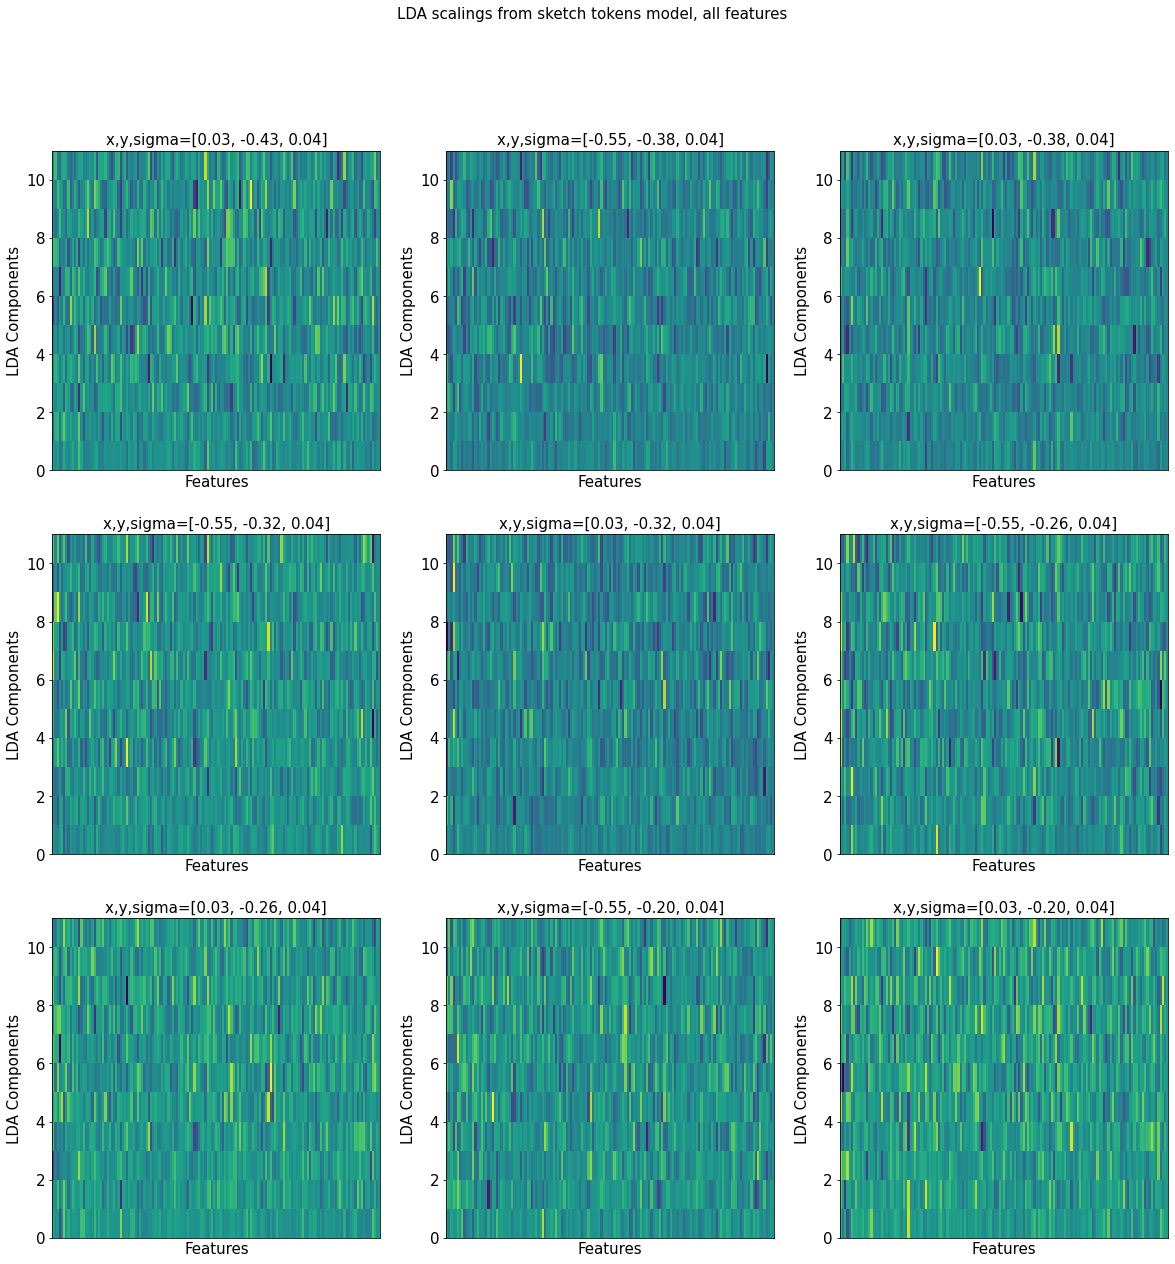

In [60]:
plot_utils.set_all_font_sizes(15)
plt.figure(figsize=(20,20));

# pcs2plot = [0,1]
# colors = cm.Set1(np.linspace(0,1,len(supcat_names)))

mm2plot = np.arange(50,140,10)
npx = int(np.ceil(np.sqrt(len(mm2plot))))
npy = int(np.ceil(len(mm2plot)/npx))

for mi, mm in enumerate(mm2plot):
    wts = wts_each_prf[mm].T
    # wts is components x features
    plt.subplot(npx,npy,mi+1)
    
    plt.pcolormesh(wts)
    
#     if mi==len(mm2plot)-npx:
#         plt.xlabel('PC %d (a.u.)'%(pcs2plot[0]+1))
#         plt.ylabel('PC %d (a.u.)'%(pcs2plot[1]+1))
    
    plt.xticks([])
#     plt.yticks([])
    
    plt.ylabel('LDA Components')
    plt.xlabel('Features')
    
    plt.title('x,y,sigma=[%.2f, %.2f, %.2f]'
          %(models[mm,0], models[mm,1], models[mm,2]));
    
plt.suptitle('LDA scalings from sketch tokens model, all features\n')
    

Text(0.5, 0.98, 'Comparing LDA scalings across models: colors are pRF models')

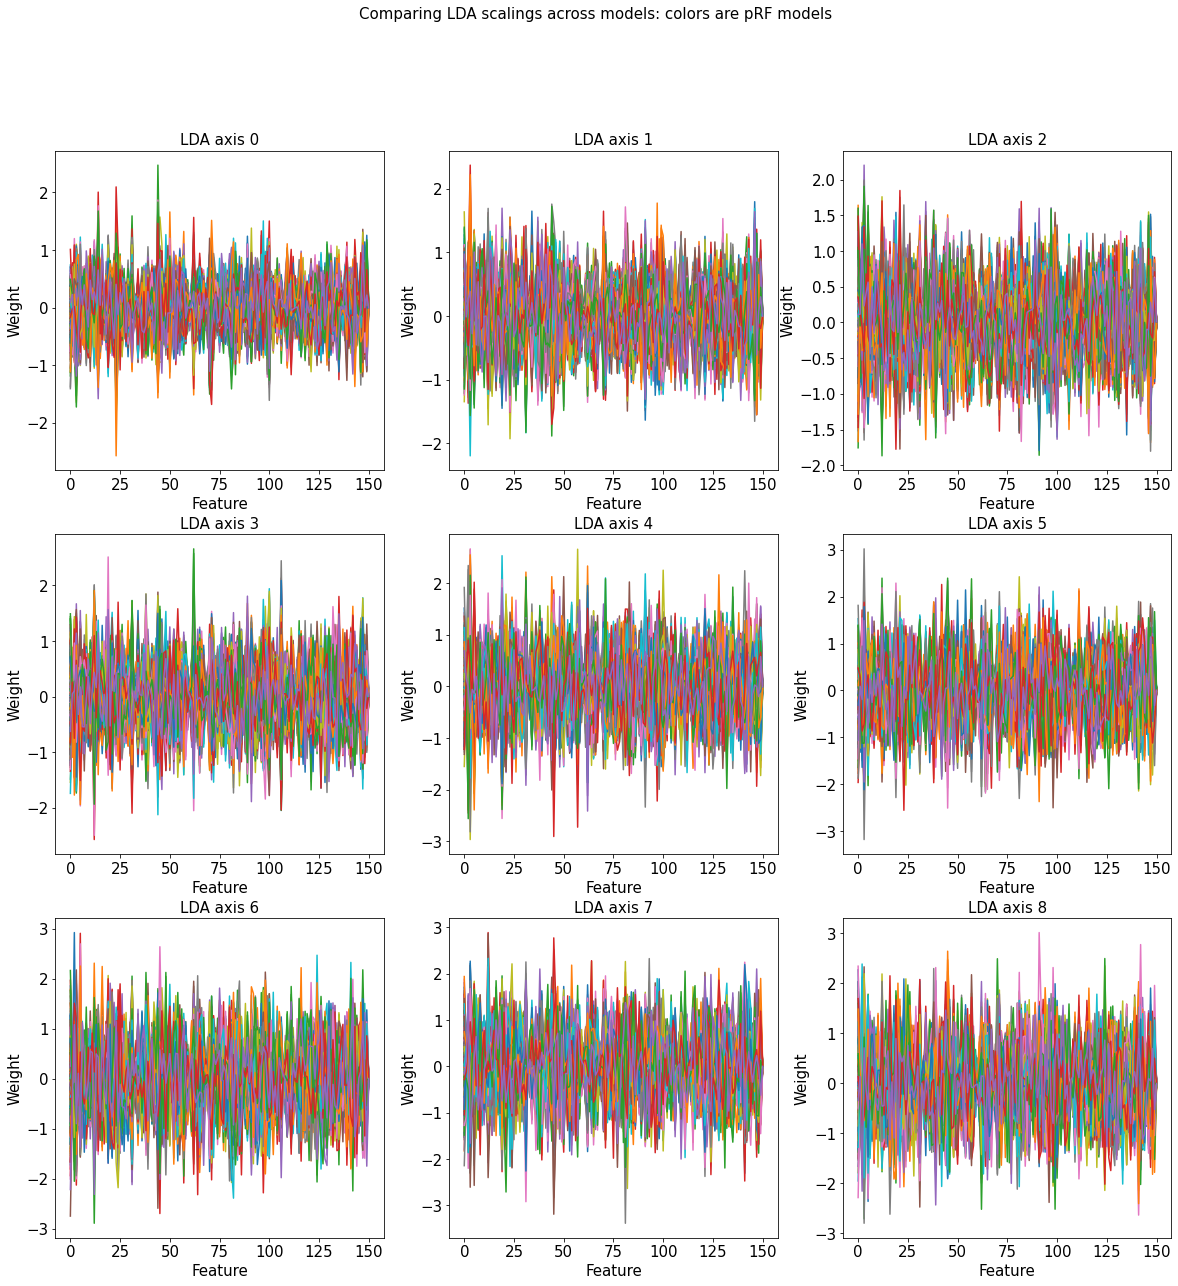

In [61]:
plt.figure(figsize=(20,20));

npx=3;npy=3
for pc in range(9):
    plt.subplot(npx,npy,pc+1)
    w2plot = np.array([wts_each_prf[mm][:,pc] for mm in range(n_prfs)])
    plt.plot(w2plot.T);
    plt.title('LDA axis %d'%pc)
    plt.xlabel('Feature')
    plt.ylabel('Weight')
    
plt.suptitle('Comparing LDA scalings across models: colors are pRF models')

In [62]:
from scipy.io import loadmat
cluster_fn = os.path.join('/user_data/mmhender/toolboxes/SketchTokens/', 'clusters.mat')
clust = loadmat(cluster_fn)
clusters = clust['clusters']['clusters'][0][0]

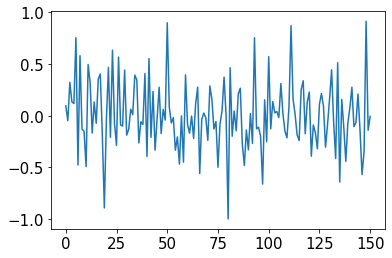

In [63]:
plt.figure();
plt.plot(wts_each_prf[mm][:,pc])

Text(0.5, 0.98, 'Sketch token features with lowest weights for LDA axis 0')

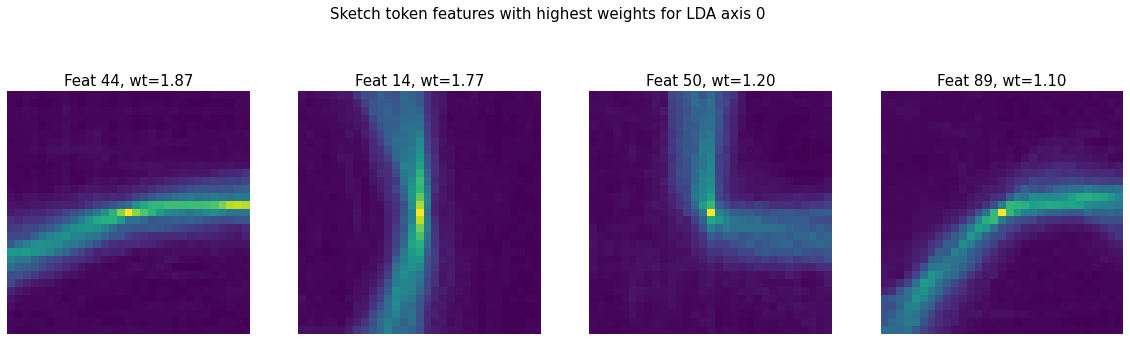

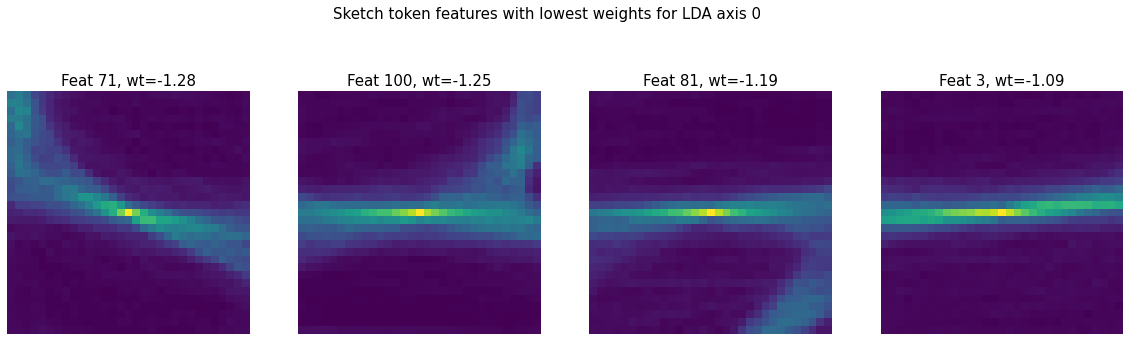

In [65]:
nclusters = clusters.shape[2]
n2plot = 4
# clusters2plot = np.random.choice(np.arange(0,nclusters), n2plot,replace=False)
pc=0
mm=866
# w = np.array([wts_each_prf[mm][pc,:] for mm in range(n_prfs)])
# wmean = np.mean(w, axis=0)
w = wts_each_prf[mm][:,pc]

clusters2plot = np.flip(np.argsort(w))[0:n2plot]

plt.figure(figsize=(20,6))
for ci,cc in enumerate(clusters2plot):
    
    plt.subplot(1,4,ci+1)
    plt.pcolormesh(clusters[:,:,cc])
    plt.axis('square')
    plt.axis('off')
    plt.gca().invert_yaxis()
    plt.title('Feat %d, wt=%.2f'%(cc, w[cc]))
    
plt.suptitle('Sketch token features with highest weights for LDA axis %d'%pc)

clusters2plot = np.argsort(w)[0:n2plot]

plt.figure(figsize=(20,6))
for ci,cc in enumerate(clusters2plot):
    
    plt.subplot(1,4,ci+1)
    plt.pcolormesh(clusters[:,:,cc])
    plt.axis('square')
    plt.axis('off')
    plt.gca().invert_yaxis()
    plt.title('Feat %d, wt=%.2f'%(cc, w[cc]))
    
plt.suptitle('Sketch token features with lowest weights for LDA axis %d'%pc)